In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import shutil

## Style sheet
plt.style.use("seaborn-v0_8-paper")
latex_installed = shutil.which("latex") is not None

rcparams = {
    "text.usetex": latex_installed,
    "font.size": 12,
    "lines.linewidth": 2,
    "mathtext.fontset": "cm", 
}

if latex_installed:
    rcparams["text.latex.preamble"] = r"\usepackage{amsmath}"
    rcparams["font.family"] = "cmu serif"
else:
    rcparams["font.family"] = "serif"

plt.rcParams.update(rcparams)

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]


## Import data, setup 

In [8]:
from data.simulated_data.generate_simulated_data import generate_simulated_data
from src.algorithms import IMMCV, RGPMT_ND, MMRGP
from src.utils import sq_exp_kernel, matern_kernel

generate_simulated_data(mc_runs=100)
data = np.load("./data/simulated_data/data.npz")

time_steps = data["time"]
true_x = data["true_x"]
true_y = data["true_y"]
meas_x = data["meas_x"]
meas_y = data["meas_y"]
mask = data["mask"]
num_mc = len(meas_x)


num_time_steps = len(time_steps)
num_measurements = np.sum(mask)
q_levels = np.array([1.0, 5.0, 10.0, 15.0, 20.0])
length_scales = np.array([1.0, 3.0, 5.0, 7.0, 9.0])
r = 0.5
num_models = len(q_levels)
num_states = 25
kernel = sq_exp_kernel
theta_init = np.array([5.0, 5.0, 0.5])


print("Number of timesteps:", num_time_steps)
print("Number of observations:", num_measurements)

Number of timesteps: 1500
Number of observations: 15186


## IMM-CV monte carlo

In [12]:
errors_imm_cv = []

for n in range(num_mc):
    meas_x_n = meas_x[n]
    meas_y_n = meas_y[n]
    imm_cv = IMMCV(q_levels, r, time_steps[1] - time_steps[0])
    est_x = np.zeros(num_time_steps)
    est_y = np.zeros(num_time_steps)
    mode_probs = np.zeros((num_time_steps, num_models))

    for k in range(num_time_steps):
        start_time = time.time()
        z = np.array([meas_x_n[k], meas_y_n[k]])
        imm_cv.predict()
        if not np.isnan(z).any():
            imm_cv.update(z)

        # Save estimates
        est_x[k] = imm_cv.x[0][0]
        est_y[k] = imm_cv.x[2][0]
        mode_probs[k] = imm_cv.mu
    
    errors = (np.array(true_x) - np.array(est_x)) ** 2 + (np.array(true_y) - np.array(est_y)) ** 2
    errors_imm_cv.append(errors)


## RGPMT monte carlo

In [4]:
errors_rgpmt = []
for n in range(num_mc):
    meas_x_n = meas_x[n]
    meas_y_n = meas_y[n]
    rgp_mt = RGPMT_ND(num_states, time_steps[0:num_states], [meas_x_n[0:num_states], meas_y_n[0:num_states]], kernel, theta_init=theta_init)
    for k in range(num_time_steps):
        z = np.array([meas_x_n[k], meas_y_n[k]])
        meas_time = time_steps[k]
        rgp_mt.step(z, meas_time)
    est_traj = rgp_mt.predicted_mean()
    est_x = est_traj[0]
    est_y = est_traj[1]

    errors = (np.array(true_x[:-1]) - np.array(est_x)) ** 2 + (np.array(true_y[:-1]) - np.array(est_y)) ** 2
    errors_rgpmt.append(errors)

## MM-RGP monte carlo

In [5]:
errors_mm_rgp = []
for n in range(num_mc):
    meas_x_n = meas_x[n]
    meas_y_n = meas_y[n]
    mm_rgp = MMRGP(kernel, time_steps[-1], length_scales, r, num_states, 1e-3, 5.0)
    for k in range(num_time_steps):
        start_time = time.time()
        z = np.array([meas_x_n[k], meas_y_n[k]])
        meas_time = time_steps[k]
        mm_rgp.time_update()
        if not np.isnan(z).any():
            mm_rgp.meas_update(z, meas_time)
    est_traj = mm_rgp.predicted_mean(time_steps)
    est_x = est_traj[0:num_time_steps]
    est_y = est_traj[num_time_steps:]
    errors = ((np.array(true_x) - np.array(est_x).T) ** 2 + (np.array(true_y).T - np.array(est_y).T) ** 2).reshape((-1,))
    errors_mm_rgp.append(errors)

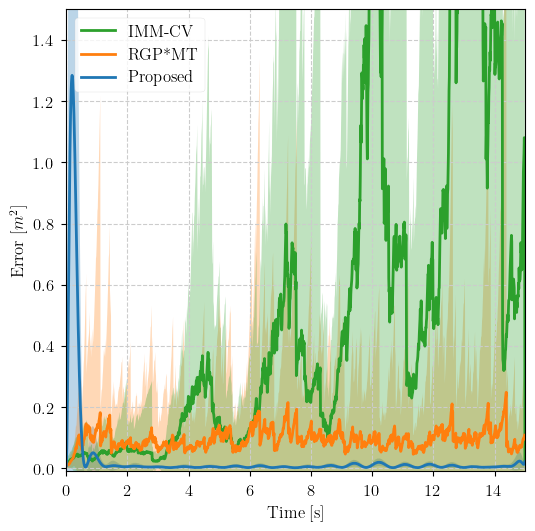

In [13]:
mean_errors_imm_cv = np.mean(errors_imm_cv, axis=0)
mean_errors_rgpmt = np.mean(errors_rgpmt, axis=0)
mean_errors_mm_rgp = np.mean(errors_mm_rgp, axis=0)

var_errors_imm_cv = np.sqrt(np.diag(np.cov(np.vstack(errors_imm_cv).T)))
var_errors_rgpmt = np.sqrt(np.diag(np.cov(np.vstack(errors_rgpmt).T)))
var_errors_mm_rgp = np.sqrt(np.diag(np.cov(np.vstack(errors_mm_rgp).T)))

# Plotting
fig1, ax1 = plt.subplots(figsize=(8, 6))

# Plot true trajectory and estimated trajectory
ax1.plot(time_steps, mean_errors_imm_cv, label="IMM-CV", lw=2.0, ls="-", color=colors[2])
ax1.plot(time_steps[:-1], mean_errors_rgpmt, label="RGP*MT", lw=2.0, ls="-", color=colors[1])
ax1.plot(time_steps, mean_errors_mm_rgp, label="Proposed", lw=2.0, ls="-", color=colors[0])

# Plot the 2-sigma bounds (shaded area around the mean)
ax1.fill_between(
    time_steps,
    mean_errors_mm_rgp - var_errors_mm_rgp,
    mean_errors_mm_rgp + var_errors_mm_rgp,
    alpha=0.3,
)

ax1.fill_between(
    time_steps[:-1],
    mean_errors_rgpmt - var_errors_rgpmt,
    mean_errors_rgpmt + var_errors_rgpmt,
    alpha=0.3,
)

ax1.fill_between(
    time_steps,
    mean_errors_imm_cv - var_errors_imm_cv,
    mean_errors_imm_cv + var_errors_imm_cv,
    alpha=0.3,
)

ax1.legend(fontsize=12)
ax1.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Error [$m^2$]", fontsize=12)
ax1.set_ylim(-0.01, 1.5)
ax1.set_xlim(0, 15)
ax1.set_aspect(10.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./figures/simulation/monte_carlo.pdf", format="pdf", bbox_inches="tight")
plt.show()
